**Business understanding**

The business objective at hand is to determine the factors that impact the price of used cars. This analysis is being prepared for a used car dealership, so we can assume the information will help the dealership to profitably buy and sell inventory. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings

# Filter out the specific FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")


In [2]:
vehicles_df = pd.read_csv('vehicles.csv')

**Data understanding**

The dataset comes from kaggle—each row represents a car for sale, and there are 426,880 rows in total. However, a significant number of columns are missing data. 

In [22]:
vehicles_df.count()

id              426880
region          426880
price           426880
year            425675
manufacturer    409234
model           421603
condition       252776
cylinders       249202
fuel            423867
odometer        422480
title_status    418638
transmission    424324
VIN             265838
drive           296313
size            120519
type            334022
paint_color     296677
state           426880
dtype: int64

**Data exploration**

Most vehicles in the data set are newer, the average year of manufacture being 2011, with a standard deviation of 9.45. 

Vehicle prices were spread widely, the average price being $75,199 with a standard deviation of $12,182,280. At first, I thought the data might contain some high value exotic cars sold at auction, but upon closer inspection, (seeing a fair condition 1999 Toyota 4Runner priced at $3.7M) it seems that these higher priced vehicles are simply bad data. Furthermore, there are vehicles with the price set at $0, which is incorrect and also useless for analysis.

Looking at the manufacturer column, the manufacturers that appear most frequently are Ford, Chevrolet, Toyota, and Honda. There are a lot of missing values in this column. There are also values of “Harley-Davidson” in this column, which isn’t relevant, since we are analyzing cars, not motorcycles.

The odometer column has an average of 98,043 miles, with a standard deviation of 213,881 miles. There are some incorrect zero values in this column—even a brand new car at a dealership has at least a few miles on it from test drives and transportation from the factory to the dealership.

All the other columns (with the exception of ‘state’ and ‘region’) have missing values

In [23]:
get_column_stats = lambda column: [column, vehicles_df[column].min(), vehicles_df[column].max(), vehicles_df[column].mean(), vehicles_df[column].std()]
pd.DataFrame([get_column_stats('year'),get_column_stats('price'),get_column_stats('odometer')], columns=['column name', 'min', 'max', 'mean', 'std'])

,column name,min,max,mean,std
0,year,1900.0,2.022000e+03,2011.235191,9.452120e+00
1,price,0.0,3.736929e+09,75199.033187,1.218228e+07
2,odometer,0.0,1.000000e+07,98043.331443,2.138815e+05


The following is a visual example of some of the problem outliers.

Text(0.5, 1.0, 'Price vs Odometer')

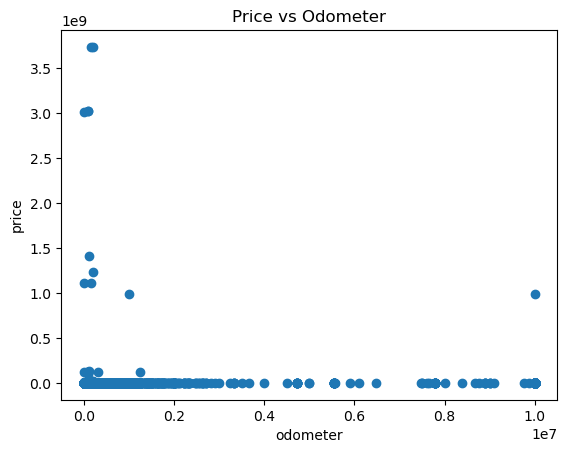

In [24]:
plt.scatter(vehicles_df['odometer'], vehicles_df['price'])
plt.xlabel('odometer')
plt.ylabel('price')
plt.title('Price vs Odometer')

And here's a look at some of the different categorical features by frequency

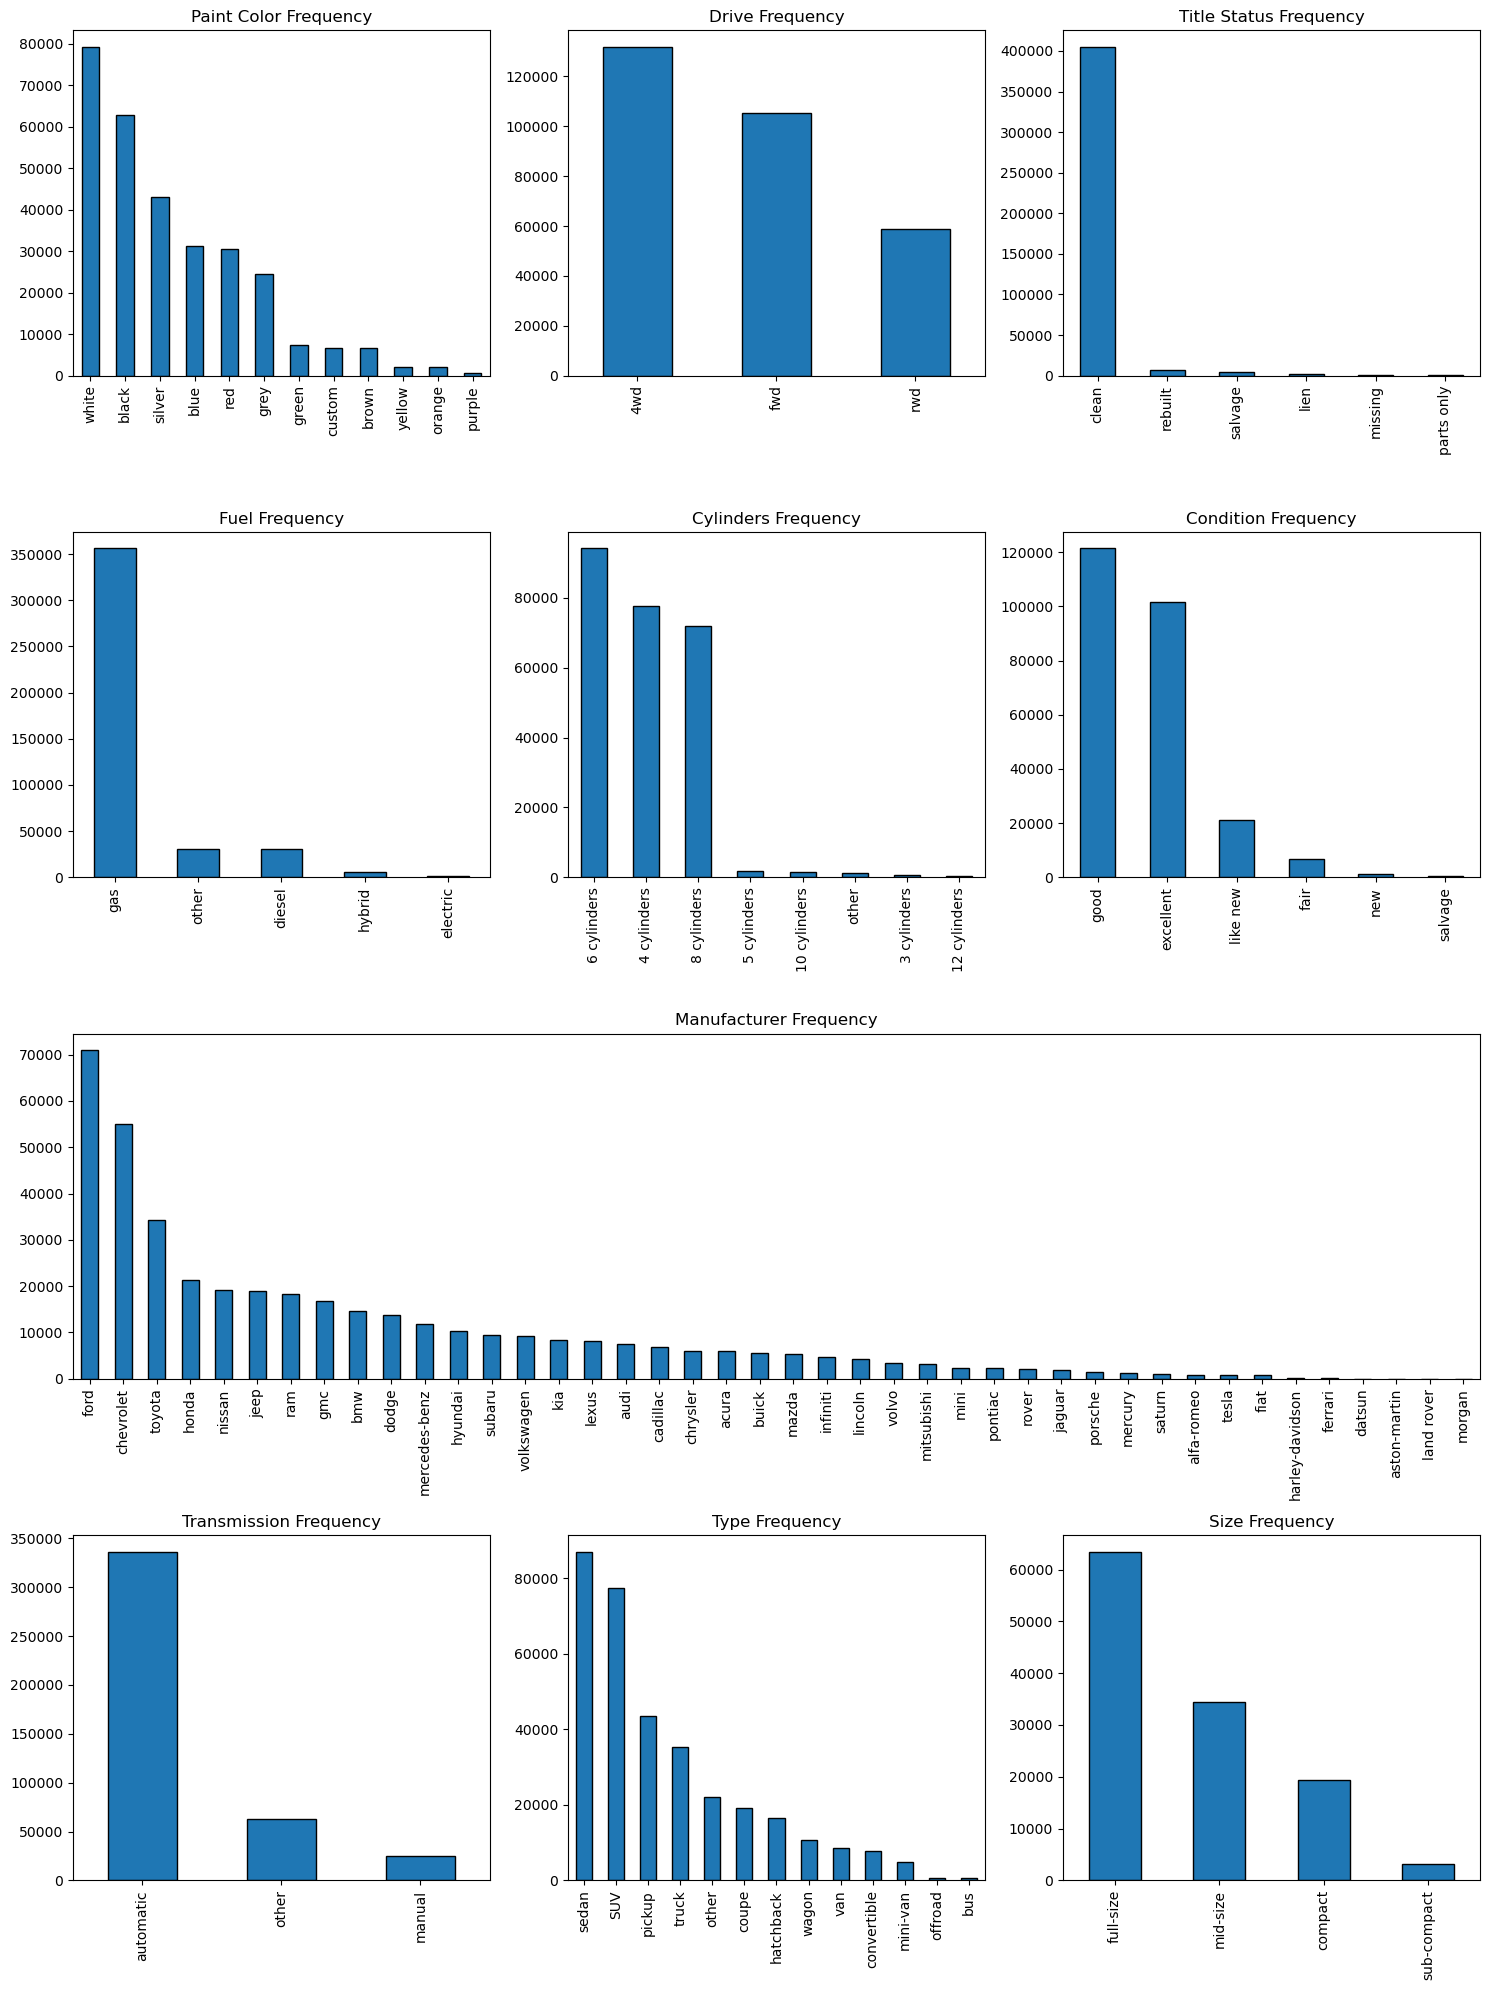

In [25]:
# Create a grid of subplots
grid_size = (4, 3)
fig, ax = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 20))

# Create a histogram of the paint colors
# Count the frequency of each category
paint_value_counts = vehicles_df['paint_color'].value_counts()
paint_value_counts.plot(kind='bar', edgecolor='black', ax=ax[0, 0])
# Set x-axis ticks to be centered under the bars
ax[0, 0].set_xticks(range(len(paint_value_counts)))
ax[0, 0].set_xticklabels(paint_value_counts.index)
ax[0, 0].set_title('Paint Color Frequency')
ax[0, 0].set_xlabel('')

# Create a histogram of the drive column
drive_value_counts = vehicles_df['drive'].value_counts()
drive_value_counts.plot(kind='bar', edgecolor='black', ax=ax[0, 1])
ax[0, 1].set_xticks(range(len(drive_value_counts)))
ax[0, 1].set_title('Drive Frequency')
ax[0, 1].set_xlabel('')

# Create a histogram of the title_status column
title_status_value_counts = vehicles_df['title_status'].value_counts()
title_status_value_counts.plot(kind='bar', edgecolor='black', ax=ax[0, 2])
ax[0, 2].set_xticks(range(len(title_status_value_counts)))
ax[0, 2].set_title('Title Status Frequency')
ax[0, 2].set_xlabel('')

# Create a histogram of the fuel column
fuel_value_counts = vehicles_df['fuel'].value_counts()
fuel_value_counts.plot(kind='bar', edgecolor='black', ax=ax[1, 0])
ax[1, 0].set_xticks(range(len(fuel_value_counts)))
ax[1, 0].set_title('Fuel Frequency')
ax[1, 0].set_xlabel('')

# Create a histogram of the cylinders column
cylinders_value_counts = vehicles_df['cylinders'].value_counts()
cylinders_value_counts.plot(kind='bar', edgecolor='black', ax=ax[1, 1])
ax[1, 1].set_xticks(range(len(cylinders_value_counts)))
ax[1, 1].set_title('Cylinders Frequency')
ax[1, 1].set_xlabel('')

# Create a histogram of the condition column
condition_value_counts = vehicles_df['condition'].value_counts()
condition_value_counts.plot(kind='bar', edgecolor='black', ax=ax[1, 2])
ax[1, 2].set_xticks(range(len(condition_value_counts)))
ax[1, 2].set_title('Condition Frequency')
ax[1, 2].set_xlabel('')

#hide the empty plots
ax[2, 0].axis('off')
ax[2, 1].axis('off')
ax[2, 2].axis('off')

ax4 = plt.subplot2grid(grid_size, (2, 0), colspan=3) 
# Create a histogram of the manufacturer column
manufacturer_value_counts = vehicles_df['manufacturer'].value_counts()
manufacturer_value_counts.plot(kind='bar', edgecolor='black', ax=ax4)
ax4.set_xticks(range(len(manufacturer_value_counts)))
ax4.set_title('Manufacturer Frequency')
ax4.set_xlabel('')

# Create a histogram of the transmission column
transmission_value_counts = vehicles_df['transmission'].value_counts()
transmission_value_counts.plot(kind='bar', edgecolor='black', ax=ax[3, 0])
ax[3, 0].set_xticks(range(len(transmission_value_counts)))
ax[3, 0].set_title('Transmission Frequency')
ax[3, 0].set_xlabel('')

# Create a histogram of the type column
type_value_counts = vehicles_df['type'].value_counts()
type_value_counts.plot(kind='bar', edgecolor='black', ax=ax[3, 1])
ax[3, 1].set_xticks(range(len(type_value_counts)))
ax[3, 1].set_title('Type Frequency')
ax[3, 1].set_xlabel('')

# Create a histogram of the size column
size_value_counts = vehicles_df['size'].value_counts()
size_value_counts.plot(kind='bar', edgecolor='black', ax=ax[3, 2])
ax[3, 2].set_xticks(range(len(size_value_counts)))
ax[3, 2].set_title('Size Frequency')
ax[3, 2].set_xlabel('')

plt.tight_layout()

**Data preparation**

Taking a look at the percentage of null values in each column of the dataset, we see the ‘size’ column is the worst offender, at 71% null, leading me to drop it. I also dropped the VIN column, as it was 38% null and essentially only serves as an ID, rather than an actual feature for the cars. I then discarded all rows with missing data. The dataset was reduced from over 400,000 initial rows to about 110,000, a significant loss, but a necessary one, as we can’t analyze which features make a car valuable if we are missing data in many of the features columns. I felt dropping rows would be more accurate than modeling the missing data.

I also dropped rows where the manufacturer was Harley-Davidson (because they make motorcycles), and where the price was less than $500 (because it’s unrealistic to list a car for less than $500).

Finally, I performed a one hot encoding of all categorical features

In [8]:
# show percentage of missing/nan values in each column
percent_missing = (vehicles_df.isnull().sum() * 100 / len(vehicles_df)).astype(int).astype(str) + "%"
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
id,0%
region,0%
price,0%
year,0%
manufacturer,4%
model,1%
condition,40%
cylinders,41%
fuel,0%
odometer,1%


In [3]:
#drop unnecessary features
vehicles_clean = vehicles_df.drop(['size','VIN','id'], axis=1).dropna()
# drop rows where manufacturer = harley davidscon
vehicles_clean = vehicles_clean[vehicles_clean['manufacturer'] != 'harley-davidson']
# combine manufacturer and model into one column
vehicles_clean['model'] = vehicles_clean['manufacturer'] + ' ' + vehicles_clean['model']
vehicles_clean = vehicles_clean.drop(['manufacturer'], axis=1)
# drop rows where price < 500
vehicles_clean = vehicles_clean[vehicles_clean['price'] >= 500]
# convert condition to numeric
condition_mapping = {'new':5, 'like new':4, 'excellent':3, 'good':2, 'fair':1, 'salvage': 0}
vehicles_clean['condition'] = vehicles_clean['condition'].replace(condition_mapping)
# Perform one-hot encoding for specified columns
categorical_columns = ['title_status', 'model', 'region','state', 'drive', 'type', 'cylinders', 'fuel', 'transmission', 'paint_color']
vehicles_clean = pd.get_dummies(vehicles_clean, columns=categorical_columns)
vehicles_clean.count()

price                 109965
year                  109965
condition             109965
odometer              109965
title_status_clean    109965
                       ...  
paint_color_purple    109965
paint_color_red       109965
paint_color_silver    109965
paint_color_white     109965
paint_color_yellow    109965
Length: 11854, dtype: int64

**Modeling**

With our cleaned dataset, when we compare a simple linear regression to a baseline that just predicts the average, we find that the linear regression has a much higher mean squared error.

Our plan to find the best model revolves around finding the model with the lowest mean squared error. We will calculate this by training the model on a training set and then comparing its predictions against the test set. The train/test split will always be done with the same random state, for consistency.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(vehicles_clean.drop(['price'], axis=1), vehicles_clean['price'], test_size=0.2, random_state=0)

In [ ]:
# create baseline model that always predicts avg price
mean_squared_error(y_test, vehicles_clean['price'].mean() * np.ones(len(y_test)))

56130572888740.53

In [ ]:
linreg = LinearRegression().fit(X_train, y_train)
mean_squared_error(y_test, linreg.predict(X_test))

1.1391127401658135e+18

When we restrict the dataset to only a few models of car (for instance, the Chevrolet Camaro, Ford Mustang, and Cadillac Escalade), the mean squared error is significantly reduced, far below the baseline.

In [ ]:
# List of models to include
models = ['camaro', 'mustang', 'escalade']

# Filter the DataFrame to include only the specified models
models_subset = vehicles_df[vehicles_df['model'].str.lower().str.contains('|'.join(models)) & vehicles_df['model'].notna()]
#drop unnecessary features
models_subset = models_subset.drop(['size','VIN','id'], axis=1).dropna()


models_subset['model'] = models_subset['manufacturer'] + ' ' + models_subset['model']
models_subset = models_subset.drop(['manufacturer'], axis=1)
# drop rows where price < 500
models_subset = models_subset[models_subset['price'] >= 500]
# convert condition to numeric
condition_mapping = {'new':5, 'like new':4, 'excellent':3, 'good':2, 'fair':1, 'salvage': 0}
models_subset['condition'] = models_subset['condition'].replace(condition_mapping)
# Perform one-hot encoding for specified columns
categorical_columns = ['title_status', 'model', 'region','state', 'fuel', 'type','drive', 'cylinders', 'transmission', 'paint_color']
models_subset = pd.get_dummies(models_subset, columns=categorical_columns)

X_train_models, X_test_models, y_train_models, y_test_models = train_test_split(models_subset.drop(['price'], axis=1), models_subset['price'], test_size=0.2, random_state=0)
linreg_models = LinearRegression().fit(X_train_models, y_train_models)
mean_squared_error(y_test_models, linreg_models.predict(X_test_models))

80182754.16640396

Let's see if we can take this idea a step further by splitting each model into its distinct generations. For example, the classic Camaros from the 1960s are sold at a much higher price point than the largely unwanted Camaros from the 1990s and early 2000s. Therefore, they shouldn't be lumped together just because they share the same name—they are completely different cars.

In [5]:
# List of models to include
models = ['camaro', 'mustang', 'escalade']

# Filter the DataFrame to include only the specified models
models_subset = vehicles_df[vehicles_df['model'].str.lower().str.contains('|'.join(models)) & vehicles_df['model'].notna()]

# Define a custom function to split models into their respective generations
def map_model(row):
    if 'camaro' in row['model']:
        if row['year'] >= 2016:
            return 'gen 6 camaro'
        elif 2010 <= row['year'] <= 2015:
            return 'gen 5 camaro'
        elif 1993 <= row['year'] <= 2002:
            return 'gen 4 camaro'
        elif 1982 <= row['year'] <= 1992:
            return 'gen 3 camaro'
        elif 1970 <= row['year'] <= 1981:
            return 'gen 2 camaro'
        elif row['year'] <= 1969:
            return 'gen 1 camaro'
    elif 'mustang' in row['model']:
        if row['year'] >= 2024:
            return 'gen 7 mustang'
        elif 2015 <= row['year'] < 2024:
            return 'gen 6 mustang'
        elif 2005 <= row['year'] < 2015:
            return 'gen 5 mustang'
        elif 1994 <= row['year'] < 2005:
            return 'gen 4 mustang'
        elif 1979 <= row['year'] < 1994:
            return 'gen 3 mustang'
        elif 1974 <= row['year'] < 1979:
            return 'gen 2 mustang'
        else:
            return 'gen 1 mustang'
    elif 'escalade' in row['model']:
        if row['year'] >= 2021:
            return 'gen 5 escalade'
        elif 2015 <= row['year'] < 2021:
            return 'gen 4 escalade'
        elif 2007 <= row['year'] < 2015:
            return 'gen 3 escalade'
        elif 2002 <= row['year'] < 2007:
            return 'gen 2 escalade'
        else:
            return 'gen 1 escalade'
    else:
        return row['model']

# Apply the custom function to create the 'gen_model' column
models_subset['model'] = models_subset.apply(map_model, axis=1)
#drop unnecessary features
models_subset = models_subset.drop(['size','VIN','id','year'], axis=1).dropna()

models_subset['model'] = models_subset['manufacturer'] + ' ' + models_subset['model']
models_subset = models_subset.drop(['manufacturer'], axis=1)
# drop rows where price < 500
models_subset = models_subset[models_subset['price'] >= 500]
# convert condition to numeric
condition_mapping = {'new':5, 'like new':4, 'excellent':3, 'good':2, 'fair':1, 'salvage': 0}
models_subset['condition'] = models_subset['condition'].replace(condition_mapping)
# Perform one-hot encoding for specified columns
categorical_columns = ['title_status', 'model', 'region','state', 'fuel', 'type','drive','cylinders', 'transmission', 'paint_color']
models_subset = pd.get_dummies(models_subset, columns=categorical_columns)

X_train_models, X_test_models, y_train_models, y_test_models = train_test_split(models_subset.drop(['price'], axis=1), models_subset['price'], test_size=0.2, random_state=0)
linreg_models = LinearRegression().fit(X_train_models, y_train_models)
mean_squared_error(y_test_models, linreg_models.predict(X_test_models))

/tmp/ipykernel_19964/4163014197.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models_subset['model'] = models_subset.apply(map_model, axis=1)


47323032.38995287

By splitting the models into generations (and removing the year feature because it's too highly correlated with the generation), we get a mean squared error of 4.73e7 (versus 8.02e7 not splitting by generation).

I then dropped features that weren't relevant, like `region` and `state` (cars are shipped all over the country, and market value isn't contingent on the location). This feature engineering brought the mean squared error to 4.22e7

In [7]:
# List of models to include
models = ['camaro', 'mustang', 'escalade']

# Filter the DataFrame to include only the specified models
models_subset = vehicles_df[vehicles_df['model'].str.lower().str.contains('|'.join(models)) & vehicles_df['model'].notna()]

# Define a custom function to split models into their respective generations
def map_model(row):
    if 'camaro' in row['model']:
        if row['year'] >= 2016:
            return 'gen 6 camaro'
        elif 2010 <= row['year'] <= 2015:
            return 'gen 5 camaro'
        elif 1993 <= row['year'] <= 2002:
            return 'gen 4 camaro'
        elif 1982 <= row['year'] <= 1992:
            return 'gen 3 camaro'
        elif 1970 <= row['year'] <= 1981:
            return 'gen 2 camaro'
        elif row['year'] <= 1969:
            return 'gen 1 camaro'
    elif 'mustang' in row['model']:
        if row['year'] >= 2024:
            return 'gen 7 mustang'
        elif 2015 <= row['year'] < 2024:
            return 'gen 6 mustang'
        elif 2005 <= row['year'] < 2015:
            return 'gen 5 mustang'
        elif 1994 <= row['year'] < 2005:
            return 'gen 4 mustang'
        elif 1979 <= row['year'] < 1994:
            return 'gen 3 mustang'
        elif 1974 <= row['year'] < 1979:
            return 'gen 2 mustang'
        else:
            return 'gen 1 mustang'
    elif 'escalade' in row['model']:
        if row['year'] >= 2021:
            return 'gen 5 escalade'
        elif 2015 <= row['year'] < 2021:
            return 'gen 4 escalade'
        elif 2007 <= row['year'] < 2015:
            return 'gen 3 escalade'
        elif 2002 <= row['year'] < 2007:
            return 'gen 2 escalade'
        else:
            return 'gen 1 escalade'
    else:
        return row['model']

# Apply the custom function to classify models by generation
models_subset['model'] = models_subset.apply(map_model, axis=1)
#drop unnecessary features
models_subset = models_subset.drop(['size','VIN','id','year','region','state'], axis=1).dropna()

models_subset['model'] = models_subset['manufacturer'] + ' ' + models_subset['model']
models_subset = models_subset.drop(['manufacturer'], axis=1)
# drop rows where price < 500
models_subset = models_subset[models_subset['price'] >= 500]
# convert condition to numeric
condition_mapping = {'new':5, 'like new':4, 'excellent':3, 'good':2, 'fair':1, 'salvage': 0}
models_subset['condition'] = models_subset['condition'].replace(condition_mapping)
# Perform one-hot encoding for specified columns
categorical_columns = ['title_status', 'model','type','fuel','cylinders', 'transmission', 'paint_color', 'drive']
models_subset = pd.get_dummies(models_subset, columns=categorical_columns)

X_train_models, X_test_models, y_train_models, y_test_models = train_test_split(models_subset.drop(['price'], axis=1), models_subset['price'], test_size=0.2, random_state=0)
linreg_models = LinearRegression().fit(X_train_models, y_train_models)
mean_squared_error(y_test_models, linreg_models.predict(X_test_models))

/tmp/ipykernel_17421/1055375020.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models_subset['model'] = models_subset.apply(map_model, axis=1)


42231112.860004306

Since 4.22e7 is still relatively high for mean squared error, I tested a model with only one model of car (the Chevrolet Camaro) and found that limiting ourselves to a single model dropped the mean squared error even further, to 2.9e7.

In [45]:
# List of models to include
models = ['camaro']
# Filter the DataFrame to include models that contain the specified models
models_subset = vehicles_df[vehicles_df['model'].str.lower().str.contains('|'.join(models)) & vehicles_df['model'].notna()]

models_subset.to_csv('export.csv', sep='\t', encoding='utf-8')


# Apply the custom function to classify models by generation
models_subset['model'] = models_subset.apply(map_model, axis=1)
#drop unnecessary features
models_subset = models_subset.drop(['size','VIN','id','year','region','state'], axis=1).dropna()

models_subset['model'] = models_subset['manufacturer'] + ' ' + models_subset['model']
models_subset = models_subset.drop(['manufacturer'], axis=1)
# drop rows where price < 500
models_subset = models_subset[models_subset['price'] >= 500]
# convert condition to numeric
condition_mapping = {'new':5, 'like new':4, 'excellent':3, 'good':2, 'fair':1, 'salvage': 0}
models_subset['condition'] = models_subset['condition'].replace(condition_mapping)
# Perform one-hot encoding for specified columns
categorical_columns = ['title_status', 'model','type','fuel','cylinders', 'transmission', 'paint_color','drive']
models_subset = pd.get_dummies(models_subset, columns=categorical_columns)

X_train_models, X_test_models, y_train_models, y_test_models = train_test_split(models_subset.drop(['price'], axis=1), models_subset['price'], test_size=0.2, random_state=0)
linreg_models = LinearRegression().fit(X_train_models, y_train_models)
mean_squared_error(y_test_models, linreg_models.predict(X_test_models))

/tmp/ipykernel_2447/3124641325.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models_subset['model'] = models_subset.apply(map_model, axis=1)


29763081.367363084

Dropping the `drive` and `fuel` features (irrelevant for the Chevrolet Camaro, as they were only ever made in rear-wheel drive, running on normal gas) brings the mean squared error down even further to 2.7e7. Deciphering the trim level from the model string and adding a categorical variable for the trim level brought the MSE down to 2.4e7. Finally, adding a scaler brought the MSE down to 2.39e7.

Although 2.39e7 might still seem high for mean squared error, the R^2 measurement is 0.82, which means the model explains 82% of the variance in the data, which is fairly thorough.

In [8]:
# List of models to include
models = ['camaro']
# Filter the DataFrame to include models that contain the specified models
# also restrict dataframe to rows where drive == rwd. The Camaro was only made in RWD. Everything else is bad data
models_subset = vehicles_df[vehicles_df['model'].str.lower().str.contains('|'.join(models)) & (vehicles_df['model'].notna())]
        
# Define a custom function to determine trim level from model column
def map_trim(row):
    model = row['model'].lower()
    if 'z28' in model or 'z 28' in model:
        return 'z28'
    elif '2ss' in model:
        return '2ss'
    elif 'ss' in model:
        return 'ss'
    elif 'rs' in model:
        return 'rs'
    elif '2lt' in model:
        return '2lt'
    elif 'lt' in model:
        return 'lt'
    elif 'zl1' in model:
        return 'zl1'
    else:
        return 'none'
    

models_subset['trim'] = models_subset.apply(map_trim, axis=1)
# Apply the custom function to classify models by generation
models_subset['model'] = models_subset.apply(map_model, axis=1)
#drop unnecessary features
models_subset = models_subset.drop(['size','VIN','id','year','region','state'], axis=1).dropna()
models_subset = models_subset.drop(['drive','fuel'], axis=1)

models_subset['model'] = models_subset['manufacturer'] + ' ' + models_subset['model']
models_subset = models_subset.drop(['manufacturer'], axis=1)
# drop rows where price < 500
models_subset = models_subset[models_subset['price'] >= 500]
# convert condition to numeric
condition_mapping = {'new':5, 'like new':4, 'excellent':3, 'good':2, 'fair':1, 'salvage': 0}
models_subset['condition'] = models_subset['condition'].replace(condition_mapping)
# Perform one-hot encoding for specified columns
categorical_columns = ['title_status', 'model','type','cylinders', 'transmission', 'paint_color', 'trim']
models_subset = pd.get_dummies(models_subset, columns=categorical_columns)

X_train_models, X_test_models, y_train_models, y_test_models = train_test_split(models_subset.drop(['price'], axis=1), models_subset['price'], test_size=0.2, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())]).fit(X_train_models, y_train_models)
print('MSE:',mean_squared_error(y_test_models, pipe.predict(X_test_models)))
print('R^2:',pipe.score(X_test_models, y_test_models))

MSE: 23929045.38096175
R^2: 0.8248603597526951


/tmp/ipykernel_17421/2670954025.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models_subset['trim'] = models_subset.apply(map_trim, axis=1)
/tmp/ipykernel_17421/2670954025.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models_subset['model'] = models_subset.apply(map_model, axis=1)


I tried many variations on the model in an attempt to improve the metrics, but as it turns out, nothing could beat simple linear regression.

In [9]:
# test polynomial features
pipe_test = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), ('linreg', LinearRegression())]).fit(X_train_models, y_train_models)
poly_mse = mean_squared_error(y_test_models, pipe_test.predict(X_test_models))
poly_r2 = pipe_test.score(X_test_models, y_test_models)

# test lasso regression
pipe_test = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(max_iter=10000))])
grid_search = GridSearchCV(pipe_test, {'lasso__alpha': np.logspace(-3, 3, 7)}, scoring='neg_mean_squared_error').fit(X_train_models, y_train_models)
# create new pipeline with best alpha
pipe_test = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=grid_search.best_params_['lasso__alpha'], max_iter=10000))]).fit(X_train_models, y_train_models)
lasso_mse = mean_squared_error(y_test_models, pipe_test.predict(X_test_models))
lasso_r2 = pipe_test.score(X_test_models, y_test_models)

# test ridge regression
pipe_test = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(max_iter=10000))])
grid_search = GridSearchCV(pipe_test, {'ridge__alpha': np.logspace(-3, 3, 7)}, scoring='neg_mean_squared_error').fit(X_train_models, y_train_models)
# create new pipeline with best alpha
pipe_test = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=grid_search.best_params_['ridge__alpha'], max_iter=10000))]).fit(X_train_models, y_train_models)

print('Polynomial Features\n===============')
print('MSE:', poly_mse)
print('R^2:', poly_r2)
print('Lasso Regression\n===============')
print('MSE:', lasso_mse)
print('R^2:', lasso_r2)
print('Ridge Regression\n===============')
print('MSE:',mean_squared_error(y_test_models, pipe_test.predict(X_test_models)))
print('R^2:',pipe_test.score(X_test_models, y_test_models))


Polynomial Features
MSE: 4.430363298931245e+28
R^2: -2.2787695287063e+20
Lasso Regression
MSE: 42951122.98141727
R^2: 0.7790797194952804
Ridge Regression
MSE: 49541397.09462764
R^2: 0.7451824636232203


**Evaluation**

The previous section details the creation of a model for one model of car. To fully accomplish the business objectives, a new model will need to be created for each model of car. To do this, the year bounds for the model generations and the trim levels will need to be known. This could be expedited with the help of a web scraper and some custom code to use the data from the web scraper to build the models.